In this project, we want to perform image classification using the *fastai* deep learning framework based on PyTorch. I will present a step-by-step solution to transfer learning in the case where we have multi-channel images.

Most commonly available pre-trained convolutional neural networks (CNNs) have been trained on RGB (3-channel) images, posing a big challenge when dealing with multi-channel images and low sample size. Training a CNN from scratch is not recommended in this particular scenario due to overfitting.

One approach to transfer learning consists in duplicating RGB weights of the first convolution layer on top of the missing channels, cycling at every 3 additional channels (i.e., RGBX image will use RGBR weights, RGBXYZ will use RGBRGB weights and so forth).

Let's start from scratch by first implementing a custom dataloader that can handle multi-channel images, then normalise the whole dataset and finally perform transfer learning.

## 1. Data preparation

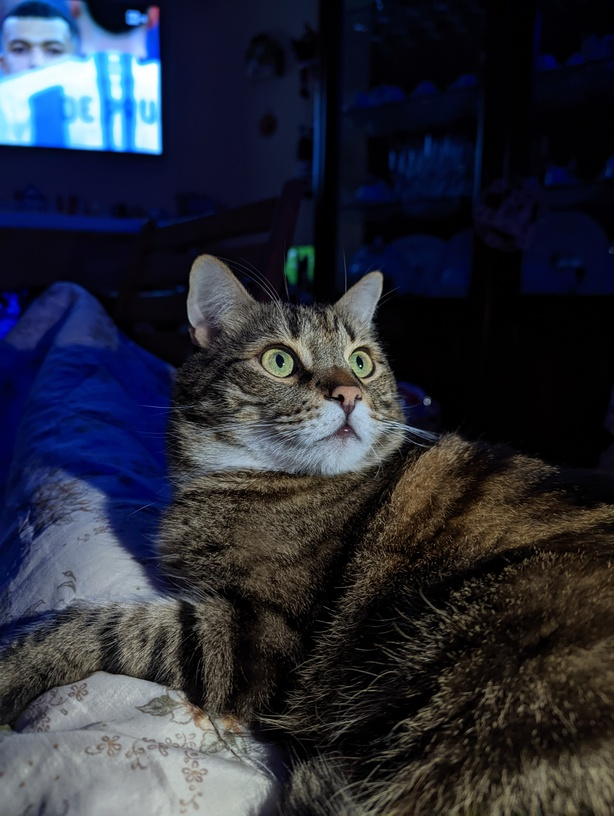

In [1]:
import os
from pathlib import Path
from PIL import Image

path_to_images = Path(os.getcwd()) / "data"
img = Image.open(path_to_images / "1.jpg")
display(img)

Let's check some properties of this figure: dimension and type

In [2]:
props = f"shape: {img.size} - type: {img.mode}"
props

'shape: (614, 816) - type: RGB'

In tensor notation, this is a stack of 3 MxN matrices (corresponding to the channels R, G, and B) with values given by pixel intensities in [0, 1]

In [3]:
from torchvision.transforms.functional import pil_to_tensor
x = pil_to_tensor(img)
props = f"shape: {x.shape}"
props

'shape: torch.Size([3, 816, 614])'

The dataset we are using for this tutorial is composed of 12 RGB images. Let's augment the number of channels for each of them by repeating the 3 channels n times (e.g., n=3) so to generate multi-channel images

In [4]:
import numpy as np
import torch

images = [Image.open(path_to_images / f"{i+1}.jpg") for i in range(12)]
x_list = [pil_to_tensor(img) for img in images]

def repeat(x, n_times=3):
    return torch.cat(n_times*[x], dim=0)

n_times = 3
x_aug_list = [repeat(x, n_times) for x in x_list]
props = f"shape: {x_aug_list[0].shape}"
props

'shape: torch.Size([9, 816, 614])'

Let's save these augmented images as multi-channel *.tif* images. Also, we construct a pandas dataframe describing a (mock) traning dataset based on the multi-channel images and we save it as a *.csv* file

In [5]:
import random

import pandas as pd
from torchvision.transforms.functional import to_pil_image

path_to_multi = path_to_images / "multi"

path_to_train = path_to_multi / "train"
path_to_train.mkdir(parents=True, exist_ok=True)

random.seed(8)  # enforcing training dataset labels reproducibility

df = pd.DataFrame()

for i, x in enumerate(x_aug_list):  # loop over all multi-channel images
    img = to_pil_image(x[0])
    img_list = [to_pil_image(x[i+1]) for i in range(3*n_times-1)]  # for each image, list each of its channels separately
    fname_i = f"{i+1}_multi"
    label_i = random.randint(0, 1)  # assign random label supposing this is a binary classification problem
    img.save(path_to_train / f"{fname_i}.tif", save_all=True, append_images=img_list)
    dct_i = {"fname": fname_i, "label": label_i, "is_valid": False, "is_test": False}  # build a dataset with no validation nor testing data points
    df = pd.concat([df, pd.DataFrame.from_dict(dct_i, orient="index").T])

df.to_csv(path_to_multi / "train.csv", index=False)

## 2. Data loaders
Now we need to define some tools to be able to deal with multi-channel images in the context of fastai

In [6]:
from PIL import ImageSequence
from functools import partial

from fastai.data.block import TransformBlock
from fastai.torch_core import TensorImage
from torchvision.transforms import ToTensor

def open_image(fn:Path) -> torch.Tensor:
    transform = ToTensor()
    img = Image.open(fn)
    x = torch.cat([transform(channel) for channel in ImageSequence.Iterator(img)], dim=0)
    return x

class MultiChannelTensor(TensorImage):
    @classmethod
    def create(cls, fn: Path) -> None:
        return cls(open_image(fn))
    
    def show(self):
        pass  # can implement custom plotting functionality here for multi-channel (n > 3) images

    def __repr__(self):
        return (f"MultiChannelTensor: {self.shape}")
    
def MultiChannelTensorBlock():
    return TransformBlock(type_tfms=partial(MultiChannelTensor.create), batch_tfms=None)

We can use the defined *MultiChannelTensorBlock* to create a data block to be fed into an image dataloader

In [7]:
from fastai.data.transforms import ColSplitter
from fastai.vision.data import CategoryBlock, ColReader, DataBlock, ImageDataLoaders

db = DataBlock(
    blocks=(MultiChannelTensorBlock, CategoryBlock),
    get_x=ColReader("fname", pref=path_to_train, suff=".tif"),
    get_y=ColReader("label"),
    splitter=ColSplitter("is_valid"),
)

db.summary(df)

Setting-up type transforms pipelines
0   1_multi     0    False   False
0   2_multi     1    False   False
0   3_multi     1    False   False
0   4_multi     0    False   False
0   5_multi     0    False   False
0   6_multi     0    False   False
0   7_multi     0    False   False
0   8_multi     0    False   False
0   9_multi     0    False   False
0  10_multi     0    False   False
0  11_multi     1    False   False
0  12_multi     0    False   False
Found 12 items
2 datasets of sizes 12,0
Setting up Pipeline: ColReader -- {'cols': 'fname', 'pref': Path('/Users/slongobardi/Projects/multi-channel-images/data/multi/train'), 'suff': '.tif', 'label_delim': None} -> partial
Setting up Pipeline: ColReader -- {'cols': 'label', 'pref': '', 'suff': '', 'label_delim': None} -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: ColReader -- {'cols': 'fname', 'pref': Path('/Users/slongobardi/Projects/multi-channel-images/data/multi/train'), 'suff': '.ti

Let's create an image dataloader to iterate over the full dataset described by the dataframe *df*. Since we only have 12 images in the dataset, we will use a batch size of 4

In [8]:
dls = ImageDataLoaders.from_dblock(
    db,
    df.loc[(df["is_valid"]==False) & (df["is_test"]==False)],
    bs=4,
    num_workers=0,
    device="cpu",
)

The issues we encounter when attempting transfer learning in fastai are related to inner methods that cannot be called because they will raise an error given they only work with images with up to 3 channels. For example, we cannot make use of the 'normalize=True' flag when constructing a vision learner because the associated internal method expects the dataset to be a set of RGB images.

To overcome this issue, we need to manually normalize the dataset by performing an 'offline' item trasformation. Let's compute first some summary statistics of the full dataset

In [10]:
def get_data_stats(dls):
    x = []
    for xi in next(iter(dls)):
        x.append(torch.Tensor(xi[0]))
    x = torch.cat(x, dim=0)
    mean = x.sum(dim=[0, 2, 3])
    std = (x**2).sum(dim=[0, 2, 3])
    count = x.shape[0] * x.shape[2] * x.shape[3]
    total_mean = mean / count
    total_var = std / count - total_mean**2
    total_std = torch.sqrt(total_var)
    return total_mean, total_std

mean, std = get_data_stats(dls)

Now we can normalise the dataset using an *ad hoc* item transformation based on the computed statistics

In [11]:
from fastcore.transform import Transform
from torchvision.transforms import Normalize

class MultiChannelNormalize(Transform):
    def __init__(self, mean, std, device="cpu"):
        self.device = device
        self.mean = mean
        self.std = std

    def encodes(self, x: MultiChannelTensor):
        t = Normalize(mean=self.mean, std=self.std)
        return t(x)

db = DataBlock(
    blocks=(MultiChannelTensorBlock, CategoryBlock),
    get_x=ColReader("fname", pref=path_to_train, suff=".tif"),
    get_y=ColReader("label"),
    splitter=ColSplitter("is_valid"),
    item_tfms=MultiChannelNormalize(mean, std),  # now we can normalise items
)

dls = ImageDataLoaders.from_dblock(
    db,
    df.loc[(df["is_valid"]==False) & (df["is_test"]==False)],
    bs=4,
    num_workers=0,
    device="cpu",
)

mean_check, std_check = get_data_stats(dls)
print(mean_check)  # close to a tensor of all 0s
print(std_check)  # close to a tensor of all 1s

tensor([-1.0915e-07,  2.5988e-08, -2.0791e-08, -1.0915e-07,  2.5988e-08,
        -2.0791e-08, -1.0915e-07,  2.5988e-08, -2.0791e-08])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


## 3. Vision learner
We are ready to define a fastai *vision learner* based on an example architecture which we know has pretrained weights available (e.g., resnet18). Make sure to switch 'normalize=False'

In [24]:
from fastai.metrics import error_rate
from fastai.vision.all import vision_learner
from fastai.vision.models import resnet18
from fastai.optimizer import ranger

learn = vision_learner(
    dls,
    resnet18,
    metrics=error_rate,
    pretrained=True,  # freeze the body (non-trainable)
    normalize=False,
    opt_func=ranger
)

We were able to initialise our learner using a multi-channel image dataset, yay! Also, we manually normalised the dataset so that we can do transfer learing!!! We are still missing something though: we need to adapt the first layer of the network to accommodate all the additional channels after the first 3. We will cycle the weights of the first 3 channels as described in the introduction

In [25]:
def make_batches(x, bs):
    if x <= bs:
        return [np.min([x, bs])]
    else:
        return [bs] + make_batches(x - bs, bs)

def create_new_weights(original_weights, n_channels):
    dst = torch.zeros(64, n_channels, 7, 7)  # resnet18 specific, hardcoded
    start = 0
    for i in make_batches(n_channels, 3):
        dst[:, start:start+i, :, :] = original_weights[:, :i, :, :]
        start += i
    return dst

def adapt_first_layer(src_model, n_channels, device):
    original_weights = src_model[0][0].weight.clone()
    new_weights = create_new_weights(original_weights, n_channels)
    new_layer = torch.nn.Conv2d(
        n_channels,
        64,  # resnet18 specific, hardcoded
        kernel_size=(7, 7),  # same
        stride=(2, 2),  # same
        padding=(3, 3),  # same
        bias=False,
    )
    new_layer.weight = torch.nn.Parameter(new_weights)
    src_model[0][0] = new_layer
    src_model.to(device)

Ok, we are ready to adapt the first layer to accommodate more than 3 channels! Notice that there are some hardcoded values you need to change in case you would want to use a different architecture

In [27]:
n_channels = 9
adapt_first_layer(learn.model, n_channels, "cpu")

learn.summary()

Sequential (Input shape: 4 x 9 x 816 x 614)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 408 x 307  
Conv2d                                    28224      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     4 x 64 x 204 x 154  
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                       

Notice that most of the parameters (body) are not targeted for training (Trainable: False) since we are doing transfer learning ('pretrained=True').

## 4. Transfer learning
We are ready to train our model! Of course 'train' is a big word, we are solving a mock / fake classification problem here just to showcase we can run a training and transfer learning on multi-channel images. First we find a suitable learning rate using fastai *lr_find* utility. Then, we fine-tune trainable parameters

/Users/slongobardi/miniforge3/envs/Py310_fastai/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


SuggestedLRs(valley=0.0020892962347716093)

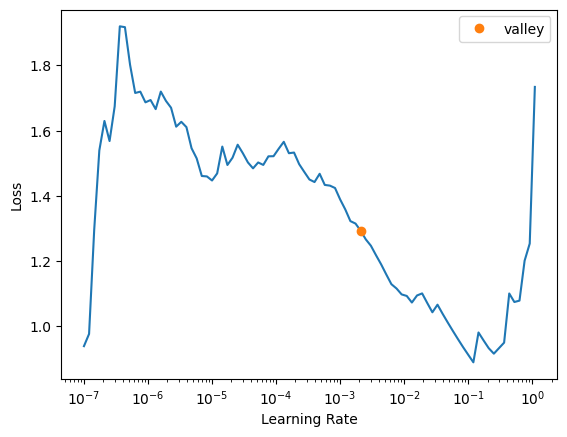

In [28]:
from fastai.torch_core import set_seed
set_seed(8, reproducible=True)  # enforcing reproducibility

learn.lr_find()

In [31]:
n_epochs = 5
lr = 2e-3
learn.fine_tune(n_epochs, lr)

epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time
0,0.733440,None,None,00:06
1,0.578637,None,None,00:06
2,0.498724,None,None,00:06
3,0.576430,None,None,00:06
4,0.672077,None,None,00:06
